In [211]:
using StochasticDelayDiffEq
using SpecialFunctions
using Distributions
using SimulatedAnnealingABC
using Distances
using DataFrames
using FFTW
using CSV
using CairoMakie
using PairPlots
using Plots
using Statistics
using StatsBase
using XLSX

In [171]:
include("./model_functions.jl")
include("./managing_functions.jl")

using .model_functions
using .managing_functions

plot_fourier_spectrum (generic function with 1 method)

In [212]:
# EXTRACTING OPEN MAGNETIC FLUX AND SUNSPOT NUMBER RECORDS FROM XLSX FILE

# Define DataFrame object
data = DataFrame(
  year = Int[],
  open_magn_flux = Float64[],
  open_magn_flux_err = Float64[],
  ssa_open_magn_flux = Float64[],
  sunspots_num = Float64[],
  sunspots_err = Float64[],
  ssa_sunspots = Float64[]
)

# Open file and for each row write data into the DataFrame
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
  sheet = file["Data"] 

  for row in XLSX.eachrow(sheet)
    if isa(row[2], Number)
      push!(data, (
        year = row[2],
        open_magn_flux = row[3],
        open_magn_flux_err = row[4],
        ssa_open_magn_flux = row[5],
        sunspots_num = row[7],
        sunspots_err = row[8],
        ssa_sunspots = row[9]
      ))
    end
  end
end

In [213]:
# Choose the directory
dir_type = "Real"
dir_num = 20

switch_dir(dir_type, dir_num)

Moved to: /home/ubuntu/LCP_B/Project/Simulations/Real 20


In [214]:
df = CSV.read("rho.csv", DataFrame)

df_squared = DataFrame()

# Iterate over each column and compute the square of each element
for col in names(df)
    df_squared[!, col] = df[!, col] .^ 2
end

row_sums = Vector{Float64}(undef, size(df, 1))

# Compute the sum of each row and store it in `row_sums`
for (i, row) in enumerate(eachrow(df_squared))
    row_sums[i] = sum(row)
end

# Now `row_sums` contains the sum of each row
k = 10  # Number of minimum values you want to find
new_indices = partialsortperm(row_sums, 1:k)  # Indices of the 5 smallest values
min_values = row_sums[new_indices]  # The 5 smallest values

println("Minimum values: ", min_values)
println("Indices of minimum values: ", new_indices)

param_samples = CSV.read("pop.csv", DataFrame)

best_particles = param_samples[new_indices, :]

#mean_particles = mean(param_samples, dims = 1)

Minimum values: [0.03190824046605339, 0.03197579334321923, 0.033817703042696455, 0.03386024603085182, 0.03451711557156809, 0.03518357900960696, 0.03659312452749942, 0.03691300834704883, 0.037604968083682105, 0.03806417033300875]
Indices of minimum values: [968, 228, 327, 329, 957, 803, 212, 507, 181, 372]


Row,N_value,T_value,tau_value,sigma_value,Bmax_value
,Float64,Float64,Float64,Float64,Float64
1,7.39336,3.21182,5.2622,0.299284,5.88976
2,13.0127,2.21213,0.651937,0.0328442,1.98171
3,8.54077,0.820459,1.97092,0.156988,8.34098
4,6.89407,3.37564,5.81711,0.0184667,6.05664
5,13.9798,7.37818,0.268819,0.192341,1.90098
6,13.7091,9.54251,2.23073,0.209977,1.95655
7,6.87051,3.09819,5.51466,0.121942,5.91145
8,7.81122,2.86046,3.80628,0.224443,5.49742
9,7.1423,3.30424,3.81365,0.108714,4.83991


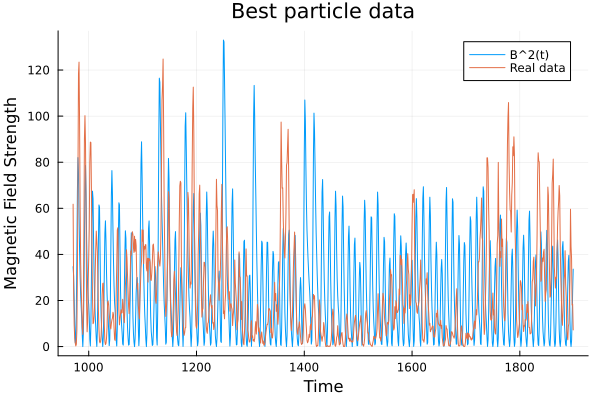

In [328]:
#par = [N, T, tau, sigma, B_max]
par = best_particles[1, :]

# Time
Tsim = [971, 1899]
dt = 0.1

# DATA SIMULATION

# Data simulation with the chosen parameter
sol = bfield(par, Tsim, dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

Plots.plot(t, u.^2, label = "B^2(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Best particle data", linewidth = 1)

Plots.plot!(data.year, data.open_magn_flux.^2, label = "Real data")

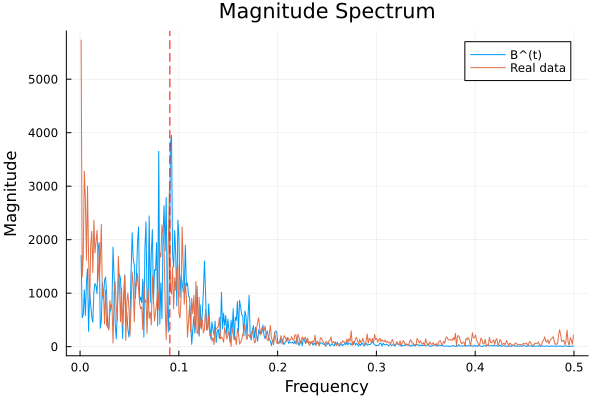

In [329]:
u = u.^2

Fs = 1 / (t[2] - t[1])
N = length(u)
freqs = fftfreq(N, Fs)

fourier_transform_sim = abs.(fft(u))

frequencies = freqs[(freqs .> 0) .& (freqs .<= 0.5)]
amplitudes = abs.(fourier_transform_sim[(freqs .> 0) .& (freqs .<= 0.5)])

Plots.plot(frequencies, amplitudes, xlabel="Frequency", ylabel="Magnitude", title="Magnitude Spectrum", label = "B^(t)")

t = data.year
u = data.open_magn_flux.^2

Fs = 1 / (t[2] - t[1])
N = length(u)
freqs = fftfreq(N, Fs)

fourier_transform_sim = abs.(fft(u))

frequencies = freqs[(freqs .> 0) .& (freqs .<= 0.5)]
amplitudes = abs.(fourier_transform_sim[(freqs .> 0) .& (freqs .<= 0.5)])
Plots.plot!(frequencies, amplitudes, label = "Real data")
vline!([1/11], line=:dash, color=:red, label=false)

In [321]:
plot_fourier_spectrum(t, u.^2)

MethodError: MethodError: no method matching plot_fourier_spectrum(::Vector{Int64}, ::Vector{Float64})

Closest candidates are:
  plot_fourier_spectrum(!Matched::Vector{Float64}, ::Vector{Float64})
   @ Main ~/LCP_B/Project/visualization_sim copy.ipynb:45


[12.548363925774844, 4.030017130852998, 1.7935962377770658, 0.014935474591429757, 2.49569744228254]


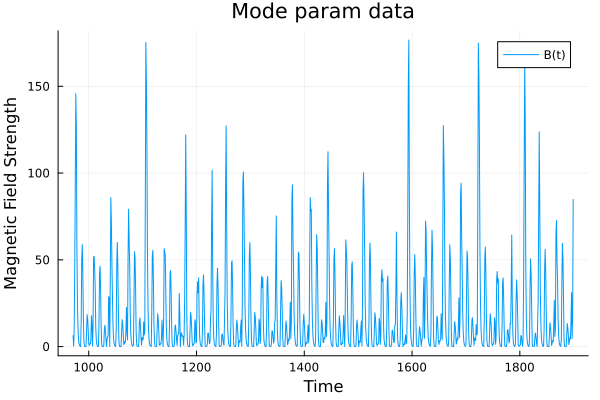

In [219]:
n_cols = size(param_samples, 2)
modes = Vector{Float64}(undef, n_cols)

# Compute mode of each column using a for loop
for col in 1:n_cols
    modes[col] = mode(param_samples[:, col])
end

println(modes)

#par = [N, T, tau, sigma, B_max]
par = modes

# Time
Tsim = [971, 1899]
dt = 0.1

# DATA SIMULATION

# Data simulation with the chosen parameter
sol = bfield(par, Tsim, dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Mode param data", linewidth = 1)

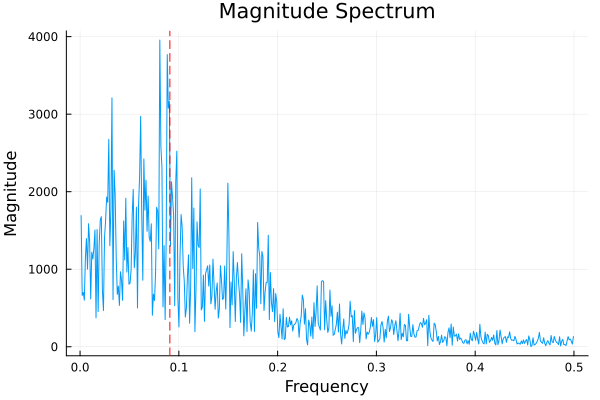

In [204]:
plot_fourier_spectrum(t, u.^2)

[9.076871548412665, 3.691916463973741, 2.8568737204595243, 0.17463410427066497, 4.1523706821727036]


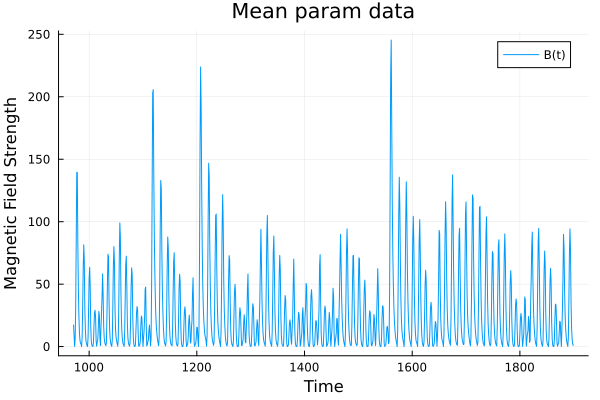

In [205]:
n_cols = size(param_samples, 2)
means = Vector{Float64}(undef, n_cols)

# Compute mode of each column using a for loop
for col in 1:n_cols
    means[col] = mean(param_samples[:, col])
end

println(means)

#par = [N, T, tau, sigma, B_max]
par = means

# Time
Tsim = [971, 1899]
dt = 0.1

# DATA SIMULATION

# Data simulation with the chosen parameter
sol = bfield(par, Tsim, dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Mean param data", linewidth = 1)

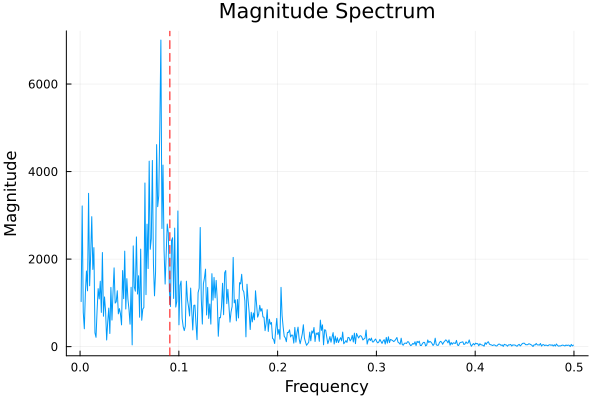

In [206]:
plot_fourier_spectrum(t, u.^2)

[9.076871548412665, 2.952873689024652, 1.7935962377770658, 0.014935474591429757, 2.49569744228254]


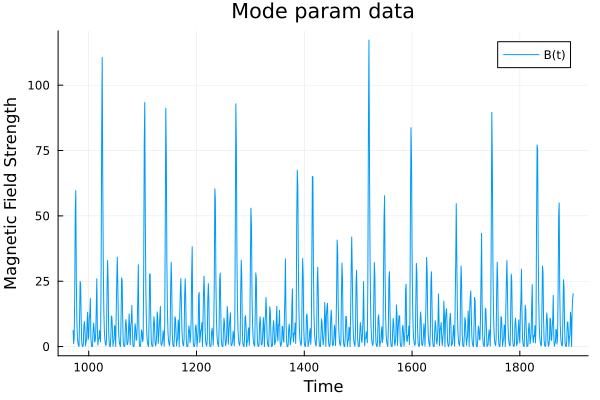

In [207]:
n_cols = size(param_samples, 2)
modes = Vector{Float64}(undef, n_cols)

# Compute mode of each column using a for loop
for col in 1:n_cols
    modes[col] = mode(param_samples[:, col])
end

N_val = param_samples[:, 1]
N_val = N_val[N_val .> 3]

modes[1] = mean(N_val)

T_val = param_samples[:, 2]
T_val = T_val[(T_val .> 0.5) .& (T_val .< 4)]

modes[2] = mean(T_val)

println(modes)

#par = [N, T, tau, sigma, B_max]
par = modes

# Time
Tsim = [971, 1899]
dt = 0.1

# DATA SIMULATION

# Data simulation with the chosen parameter
sol = bfield(par, Tsim, dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Mode param data", linewidth = 1)

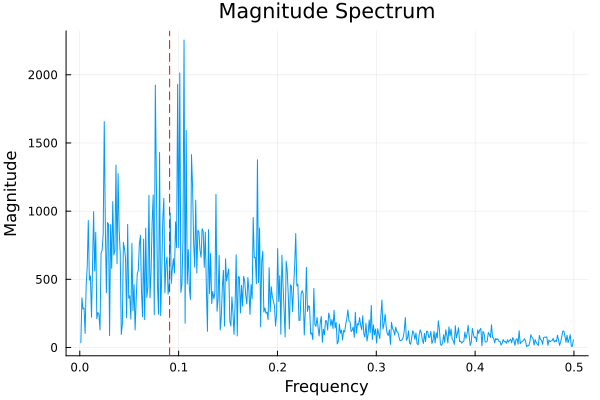

In [208]:
plot_fourier_spectrum(t, u.^2)

In [209]:
cd("/home/ubuntu/LCP_B/Project")